In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
with open('data/shell_comparison_RAL.json') as f:
    data = json.load(f)
    df_runs = pd.json_normalize(data)
    df_runs.columns = [col.split('.')[-1] for col in df_runs.columns]
    
    df_runs = df_runs[df_runs['planner'] != 'cuttingplane']
    df_runs = df_runs[df_runs['planner'] != 'cylinder']

    df_runs['planner'] = df_runs['planner'].str\
        .replace('cgal', 'Convex Hull Geodesics')\
        .replace('cuttingplane', 'Cutting Plane Heuristic')\
        .replace('cylinder', 'Minimum Enclosing Cylinder')\
        .replace('sphere', 'Minimum Enclosing Sphere')

In [3]:
agged = df_runs.groupby(['scene','planner']).agg(['mean','sem'])[['total_experiment_runtime','total_path_length','n_visited']]

In [4]:
agged

total_experiment_runtime              \
                                                       mean         sem   
scene     planner                                                         
appletree Convex Hull Geodesics                     40579.6  705.065004   
          Minimum Enclosing Sphere                  41647.6  500.642647   

                                   total_path_length           n_visited  \
                                                mean       sem      mean   
scene     planner                                                          
appletree Convex Hull Geodesics           502.528063  9.074378     149.4   
          Minimum Enclosing Sphere        556.936704  9.744613     147.4   

                                              
                                         sem  
scene     planner                             
appletree Convex Hull Geodesics     0.812404  
          Minimum Enclosing Sphere  1.077033

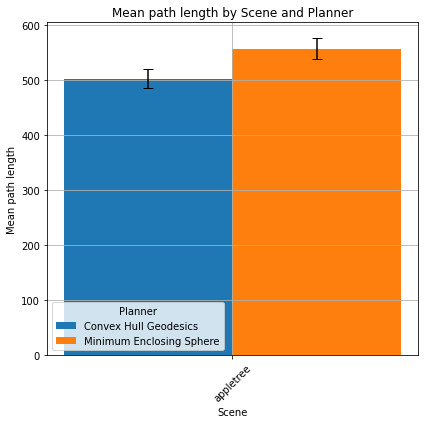

In [5]:
plt.figure(figsize=(6,6))

scene_order = agged.index.get_level_values('scene').unique()
planner_order = agged.index.get_level_values('planner').unique()

bar_width = 0.2
bar_positions = {}
for i, planner in enumerate(planner_order):
    bar_positions[planner] = [j + i * bar_width for j in range(len(scene_order))]


for planner in planner_order:
    plt.bar(bar_positions[planner], agged.loc[pd.IndexSlice[:, planner], ('total_path_length', 'mean')], 
           width=bar_width, label=planner,
           yerr=agged.loc[pd.IndexSlice[:, planner], ('total_path_length', 'sem')] * 1.96,
           capsize=5)

plt.xticks([pos + bar_width * (len(planner_order) - 1) / 2 for pos in bar_positions[planner_order[0]]], scene_order, rotation = 45)
plt.xlabel('Scene')
plt.ylabel(f'Mean path length')
plt.title(f'Mean path length by Scene and Planner')
plt.grid()
plt.legend(title='Planner')

plt.tight_layout()
plt.savefig('comparison_trees_vertical.pdf')
plt.show()

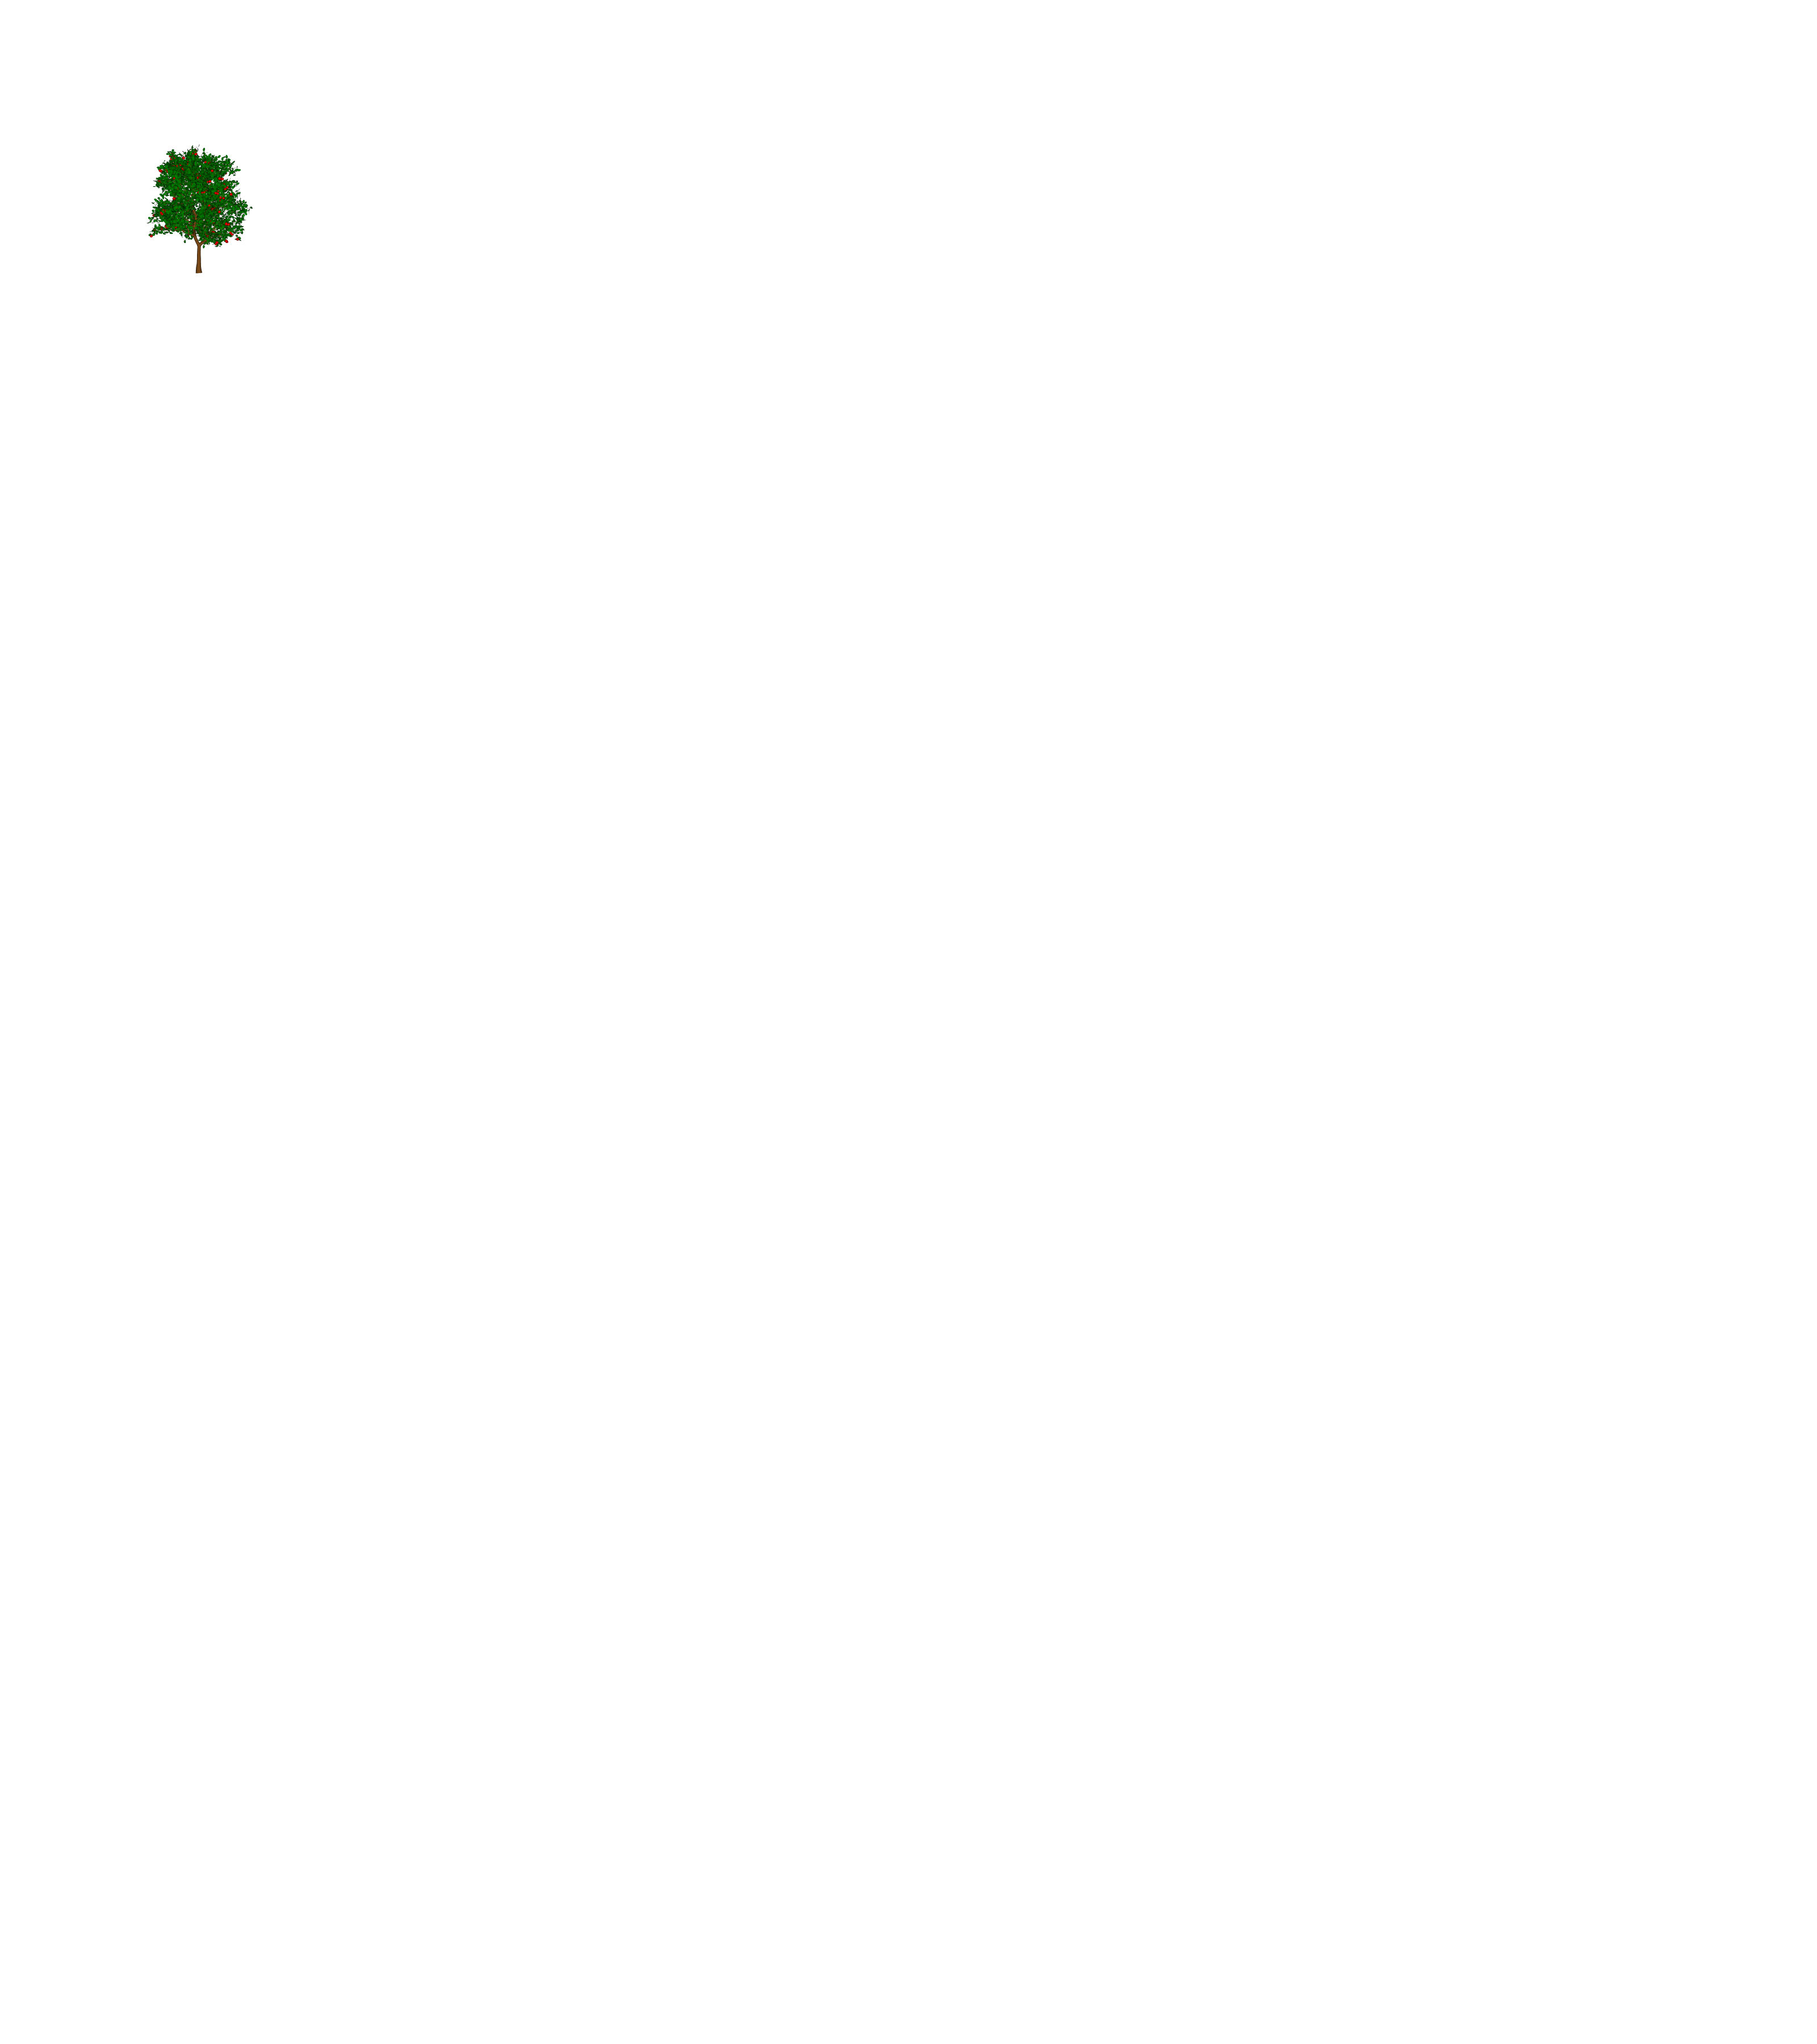

In [6]:
from PIL import Image
import os

# Directory containing images
dir_path = "/home/werner/ws_moveit2/src/motion-planning-around-apple-trees/tree_pics"

image_files = [os.path.join(dir_path,name+'.png') for name in df_runs['scene'].unique()]

# Grid dimensions
ROWS = 6
COLS = 4

VCROP_AMOUNT = 0
HCROP_AMOUNT = 50

image_sample = Image.open(image_files[0])
width, height = image_sample.size
width -= 2 * HCROP_AMOUNT
height -= 2 * VCROP_AMOUNT

# Assuming all images are the same size, get dimensions of first image
width, height = Image.open(image_files[0]).size

# Create a new image of size ROWSxCOLS (width x height)
grid_img = Image.new('RGBA', (width * COLS, height * ROWS))

x = 0
y = 0

# Calculate the total number of images
total_images = len(image_files)

for index, image_file in enumerate(image_files):
    
    img = Image.open(os.path.join(dir_path, image_file))
    
    img = img.crop((HCROP_AMOUNT, HCROP_AMOUNT, img.width - HCROP_AMOUNT, img.height - VCROP_AMOUNT))

    # For the last row, if there are less than COLS images, adjust x to center the images
    if y == height * (ROWS - 1) and total_images % COLS != 0:
        x = width * ((COLS - total_images % COLS) // 2)  # the remaining space divided by 2

    # Paste the image at location x, y
    grid_img.paste(img, (x, y))

    # Update the position for the next image
    x += width
    if x >= grid_img.width or (y == height * (ROWS - 1) and (index + 1) % COLS == 0):
        x = 0
        y += height

# Save the grid image
grid_img.save("grid_image.png", "PNG")

grid_img